
# Predicting Customer Credit Mix — Short Comments, No Imports
**Date:** 2025-09-29

> Note: This notebook **assumes** libraries are already imported (e.g., `pandas as pd`, `numpy as np`, `matplotlib.pyplot as plt`, `seaborn as sns`, scikit-learn modules).  
> Add your own imports cell separately if needed.


In [7]:
import warnings
warnings.filterwarnings('ignore')

# ডেটা ও ভিজ্যুয়ালাইজেশন
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# প্রিপ্রসেসিং ও মডেলিং
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ক্লাসিফায়ার মডেল
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ইভ্যালুয়েশন মেট্রিকস
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             precision_recall_fscore_support)

# ইম্পর্ট্যান্স (Permutation Importance)
from sklearn.inspection import permutation_importance

# গ্লোবাল ভিজ স্টাইল
sns.set(style="whitegrid")
np.random.seed(42)


In [8]:

# Load dataset from URL
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/Bank%20Data.csv'
df = pd.read_csv(url)          # read CSV
print("Shape:", df.shape)      # show rows, cols
df.head()                      # preview


Shape: (50000, 27)


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


In [9]:

# Quick overview of data
df.info()                      # dtypes and non-nulls
df.isna().sum().sort_values(ascending=False).head(10)  # top missing
df.describe(include='all').T.head(15)                  # basic stats


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,50000,50000,0x160a,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_ID,50000,12500,CUS_0xd40,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,50000,4,September,12500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name,44985,10139,Stevex,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,50000,976,39,1493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SSN,50000,12501,#F%$D@*&8,2828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,50000,16,_______,3438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual_Income,50000,16121,109945.32,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monthly_Inhand_Salary,42502.0,NaN,NaN,NaN,4182.004291,3174.109304,303.645417,1625.188333,3086.305,5934.189094,15204.633333
Num_Bank_Accounts,50000.0,NaN,NaN,NaN,16.83826,116.396848,-1.0,3.0,6.0,7.0,1798.0


In [10]:

# Define target and split features
target_col = 'Credit_Mix'      # target column
df = df.dropna(subset=[target_col]).copy()            # drop rows with missing target
y = df[target_col].astype(str) # ensure categorical as string
X = df.drop(columns=[target_col])                     # features only
y.value_counts()              # class counts


Credit_Mix
Standard    18379
Good        12260
_            9805
Bad          9556
Name: count, dtype: int64

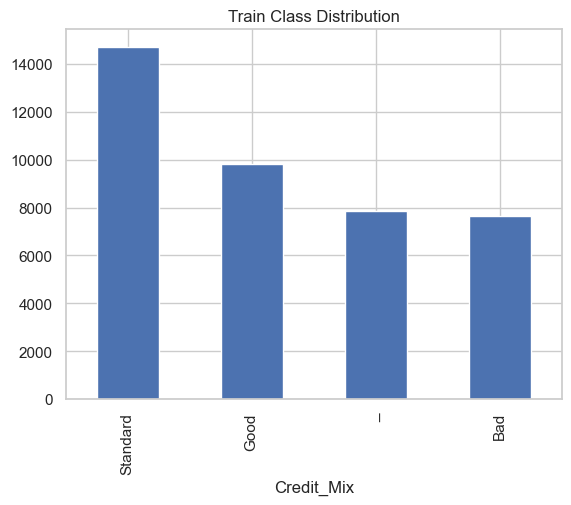

In [11]:

# Stratified train/test split to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Detect numeric and categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Plot training class distribution
y_train.value_counts().plot(kind='bar'); plt.title('Train Class Distribution'); plt.show()


In [12]:

# Build preprocessing: impute + scale (numeric), impute + one-hot (categorical)
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # fill numeric NaNs
    ("scaler", RobustScaler())                       # scale robustly
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),   # fill cat NaNs
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # one-hot
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_preprocess, num_cols),
    ("cat", categorical_preprocess, cat_cols)
])
preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                                  'Num_Credit_Card', 'Interest_Rate',
                                  'Delay_from_due_date', 'Num_Credit_Inquiries',
                                  'Credit_Utilization_Ratio',
                                  'Total_EMI_per_month']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer...
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['ID', 'Customer_ID', 'Month', 'Name', 'Age',
                                  'SSN', 'Occupation', 'Annual_Income',
                                  'Num_of_Loan', 'Type_of_Loan',
                                  'Num_of_Delayed_Payment',
                                  'Changed_Credit_Limit', 'Outstanding_Debt',
                                  'Credit_History_Age', 'Payment_of_Min_Amount',
                                  'Amount_invested_monthly',
                                  'Payment_Behaviour', 'Monthly_Balance'])])

In [13]:

# Helper to train, predict, and print metrics
def evaluate(pipe, X_tr, y_tr, X_te, y_te, average='weighted'):
    pipe.fit(X_tr, y_tr)                  # train
    p = pipe.predict(X_te)                # predict
    acc = accuracy_score(y_te, p)         # accuracy
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, p, average=average, zero_division=0)
    print(f"Accuracy:{acc:.4f} Precision:{pr:.4f} Recall:{rc:.4f} F1:{f1:.4f}")
    print(classification_report(y_te, p, zero_division=0))   # full report
    cm = confusion_matrix(y_te, p)        # confusion matrix
    sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()
    return {"acc":acc, "f1":f1, "pred":p}


In [14]:
# Categorical pipeline: make sparse, 32-bit, group rare levels
categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # ✅ scikit-learn >=1.2: use `sparse_output=True`
    ("ohe", OneHotEncoder(handle_unknown="ignore",
                          sparse_output=True,
                          dtype=np.float32,
                          min_frequency=0.005))  # 0.5% এর কম ফ্রিকোয়েন্সি হলে একসাথে গ্রুপ
])

# 👉 যদি আপনার scikit-learn পুরনো হয় (<=1.1), তবে উপরের লাইনে `sparse_output=True` এর বদলে `sparse=True` দিন:
# OneHotEncoder(..., sparse=True, dtype=np.float32, min_frequency=0.005)


In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),   # আপনার numeric_preprocess আগের মতই থাকবে
        ("cat", categorical_preprocess, cat_cols)
    ],
    # sparse_threshold ডিফল্ট 0.3 থাকে—OHE বড় হলে আউটপুট সাধারণত স্পার্সই হবে
)


=== Logistic Regression (Sparse) ===
Accuracy:0.6629 Precision:0.5749 Recall:0.6629 F1:0.5957
              precision    recall  f1-score   support

         Bad       0.66      0.93      0.77      1911
        Good       0.63      0.94      0.76      2452
    Standard       0.72      0.69      0.70      3676
           _       0.15      0.01      0.02      1961

    accuracy                           0.66     10000
   macro avg       0.54      0.64      0.56     10000
weighted avg       0.57      0.66      0.60     10000



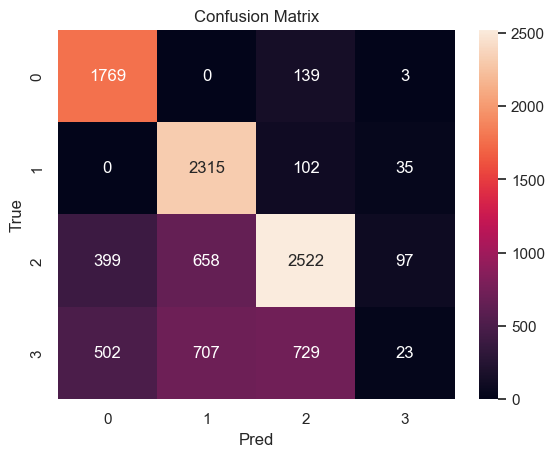

In [16]:
logreg_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        solver="saga",      # ✅ স্পার্স সাপোর্টেড, বড় ডেটায় ভালো
        n_jobs=-1           # মাল্টিকোর
    ))
])

print("=== Logistic Regression (Sparse) ===")
res_log = evaluate(logreg_pipe, X_train, y_train, X_test, y_test)


In [17]:
from sklearn.decomposition import TruncatedSVD

svd_dim = 300  # প্রয়োজনমতো টিউন করুন (100–500 ভাল শুরু)
logreg_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("svd", TruncatedSVD(n_components=svd_dim, random_state=42)),  # ✅ স্পার্সে কাজ করে
    ("clf", LogisticRegression(max_iter=1000, solver="saga", n_jobs=-1))
])


In [18]:
from sklearn.feature_selection import SelectKBest, chi2

logreg_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("kbest", SelectKBest(chi2, k=5000)),  # top 5k OHE features
    ("clf", LogisticRegression(max_iter=1000, solver="saga", n_jobs=-1))
])


=== Logistic Regression ===
Accuracy:0.6784 Precision:0.5745 Recall:0.6784 F1:0.6048
              precision    recall  f1-score   support

         Bad       0.65      0.95      0.77      1911
        Good       0.66      0.93      0.77      2452
    Standard       0.72      0.73      0.73      3676
           _       0.11      0.00      0.00      1961

    accuracy                           0.68     10000
   macro avg       0.54      0.65      0.57     10000
weighted avg       0.57      0.68      0.60     10000



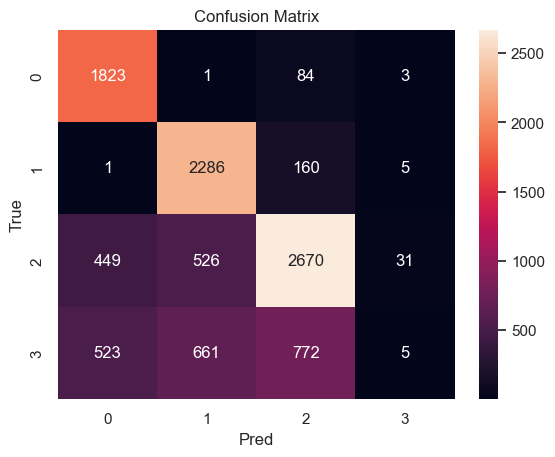

In [19]:

# Baseline model: Logistic Regression
logreg_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])
print("=== Logistic Regression ===")
res_log = evaluate(logreg_pipe, X_train, y_train, X_test, y_test)


=== Random Forest ===
Accuracy:0.7631 Precision:0.6668 Recall:0.7631 F1:0.6843
              precision    recall  f1-score   support

         Bad       0.76      0.97      0.85      1911
        Good       0.77      0.97      0.86      2452
    Standard       0.77      0.92      0.84      3676
           _       0.26      0.01      0.02      1961

    accuracy                           0.76     10000
   macro avg       0.64      0.72      0.64     10000
weighted avg       0.67      0.76      0.68     10000



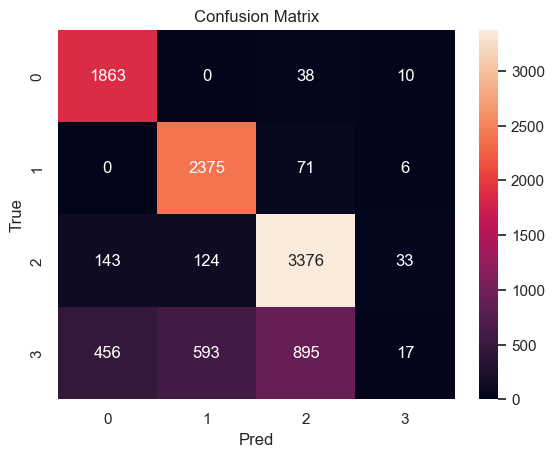

In [20]:

# Baseline model: Random Forest
rf_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])
print("=== Random Forest ===")
res_rf = evaluate(rf_pipe, X_train, y_train, X_test, y_test)


In [21]:

# Cross-validation (Stratified 5-fold) on training set using F1-weighted
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_f1(pipe, X, y):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_weighted", n_jobs=-1)
    print("CV F1_weighted:", np.round(scores,4))
    print("Mean±Std:", scores.mean().round(4), "±", scores.std().round(4))
    return scores

print("Logistic Regression CV:")
_ = cv_f1(logreg_pipe, X_train, y_train)

print("\nRandom Forest CV:")
_ = cv_f1(rf_pipe, X_train, y_train)


Logistic Regression CV:
CV F1_weighted: [0.5941 0.6051 0.5952 0.5935 0.597 ]
Mean±Std: 0.597 ± 0.0042

Random Forest CV:
CV F1_weighted: [0.6777 0.682  0.6757 0.6738 0.6806]
Mean±Std: 0.678 ± 0.0031


In [ ]:

# Hyperparameter tuning for Random Forest (GridSearch)
param_grid = {
    "clf__n_estimators": [200, 300, 500],      # trees
    "clf__max_depth": [None, 10, 20],          # depth
    "clf__min_samples_split": [2, 5, 10],      # split min
    "clf__min_samples_leaf": [1, 2, 4]         # leaf min
}

grid = GridSearchCV(rf_pipe, param_grid, cv=cv, scoring="f1_weighted", n_jobs=-1)
grid.fit(X_train, y_train)                     # search best params
print("Best params:", grid.best_params_)       # show best
print("Best CV score:", grid.best_score_)      # show best score

best_rf = grid.best_estimator_                 # get best pipeline
print("\n=== Tuned RF on Test ===")
_ = evaluate(best_rf, X_train, y_train, X_test, y_test)   # final test metrics


In [ ]:
best_rf.fit(X_train, y_train)  # fit tuned model

# permutation importance on the *pipeline* (original feature space)
r = permutation_importance(best_rf, X_test, y_test,
                           n_repeats=10, random_state=42,
                           scoring='f1_weighted')

# use original column names (length matches r.importances_mean)
feature_names = X_test.columns

imp = pd.Series(r.importances_mean, index=feature_names)\
        .sort_values(ascending=False).head(20)

display(imp)
imp.iloc[::-1].plot(kind='barh'); plt.title('Top Permutation Importances'); plt.tight_layout(); plt.show()


In [ ]:
# === Permutation Importance — choose ONE mode: "original" or "transformed" ===
MODE = "original"      # change to "transformed" for OHE-level details
N_REPEATS = 10         # lower to 5 for speed
SAMPLE = None          # e.g., 2000 to sample 2k rows for faster run

# (1) fit once
best_rf.fit(X_train, y_train)

# (2) optional down-sample test for speed
if SAMPLE:
    X_eval = X_test.sample(min(SAMPLE, len(X_test)), random_state=42)
    y_eval = y_test.loc[X_eval.index]
else:
    X_eval, y_eval = X_test, y_test

if MODE == "original":
    # --- A) pipeline-level importance in ORIGINAL feature space ---
    # Short: fast, low memory; 1 importance per original column
    r_orig = permutation_importance(
        best_rf, X_eval, y_eval, n_repeats=N_REPEATS,
        random_state=42, scoring="f1_weighted"
    )
    feat_names_orig = X_eval.columns
    imp_orig = (pd.Series(r_orig.importances_mean, index=feat_names_orig)
                  .sort_values(ascending=False)
                  .head(20))
    display(imp_orig)
    imp_orig.iloc[::-1].plot(kind='barh')
    plt.title('Top Permutation Importances (Original Features)')
    plt.tight_layout(); plt.show()

elif MODE == "transformed":
    # --- B) classifier-level importance in TRANSFORMED (OHE) space ---
    # Short: detailed per OHE dummy; slower/more memory
    prep = best_rf.named_steps['prep']
    Xt_eval = prep.transform(X_eval)                # may be sparse
    est = best_rf.named_steps['clf']

    r_tr = permutation_importance(
        est, Xt_eval, y_eval, n_repeats=N_REPEATS,
        random_state=42, scoring="f1_weighted"
    )

    # build transformed feature names
    num_names = list(prep.transformers_[0][2])      # numeric original names
    ohe = prep.named_transformers_['cat'].named_steps['ohe']
    cat_base = prep.transformers_[1][2]             # original categorical cols
    try:
        cat_names = list(ohe.get_feature_names_out(cat_base))
    except AttributeError:
        cat_names = list(ohe.get_feature_names(cat_base))  # older sklearn

    feature_names_tr = num_names + cat_names
    assert Xt_eval.shape[1] == len(feature_names_tr), \
        f"Transformed dims {Xt_eval.shape[1]} != names {len(feature_names_tr)}"

    imp_tr = (pd.Series(r_tr.importances_mean, index=feature_names_tr)
                .sort_values(ascending=False)
                .head(20))
    display(imp_tr)
    imp_tr.iloc[::-1].plot(kind='barh')
    plt.title('Top Permutation Importances (Transformed/OHE)')
    plt.tight_layout(); plt.show()
else:
    raise ValueError("MODE must be 'original' or 'transformed'")


In [ ]:

# (Optional) Save best pipeline 

In [ ]:
import joblib
joblib.dump(best_rf, "credit_mix_best_rf.pkl")
print("Saved: credit_mix_best_rf.pkl")
